# Intro
I aim to see what we can expect the mid price to do, when we observe trade ticks

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# for checking price movement
__order_book = pd.read_csv('[market_data_2] order_book.csv')
etf_book = __order_book[__order_book['instrument'] == "ETF"]
etf_book['mid'] = etf_book.apply(
    lambda row: (row['bidPrice0'] + row['askPrice0']) / 2,
    axis = 1
)

# for the signals
__trade_ticks = pd.read_csv('[market_data_2] trade_ticks.csv')
etf_ticks = __trade_ticks[__trade_ticks['instrument'] == "ETF"]

def get_total_orders(row, side):
        total = 0
        for level in ['4', '3', '2', '1', '0']:
            total += row[side + 'Vol' + level]

        return total

etf_ticks['total_bids'] = etf_ticks.apply(lambda row: get_total_orders(row, "bid"), axis=1)
etf_ticks['total_asks'] = etf_ticks.apply(lambda row: get_total_orders(row, "ask"), axis=1)
etf_ticks['volume_imbalance'] = (etf_ticks['total_bids'] - etf_ticks['total_asks']) / (etf_ticks['total_bids'] + etf_ticks['total_asks'])

/var/folders/y1/j8q13m8j2zz_7c2qmpq3frzr0000gn/T/ipykernel_7849/2598228918.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  etf_book['mid'] = etf_book.apply(
/var/folders/y1/j8q13m8j2zz_7c2qmpq3frzr0000gn/T/ipykernel_7849/2598228918.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  etf_ticks['total_bids'] = etf_ticks.apply(lambda row: get_total_orders(row, "bid"), axis=1)
/var/folders/y1/j8q13m8j2zz_7c2qmpq3frzr0000gn/T/ipykernel_7849/2598228918.py:24: SettingWithCopyWarning: 
A value is trying to be 

# Plot histogram of volume imbalance
Conclude that we only get trade ticks on one side of the book.

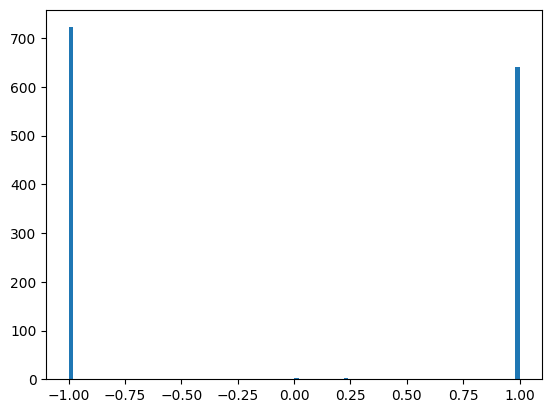

In [6]:
plt.hist(etf_ticks['volume_imbalance'], bins=100)
plt.show()

Now try plotting raw trade volumes

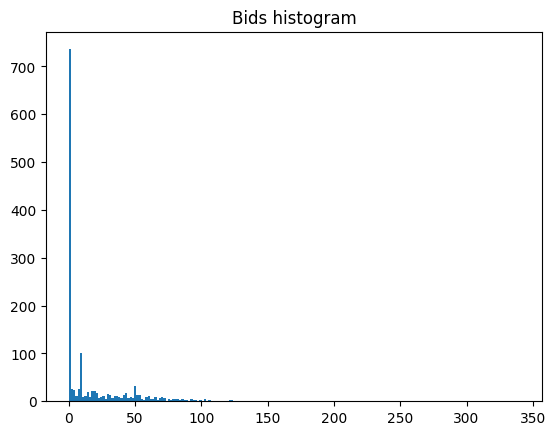

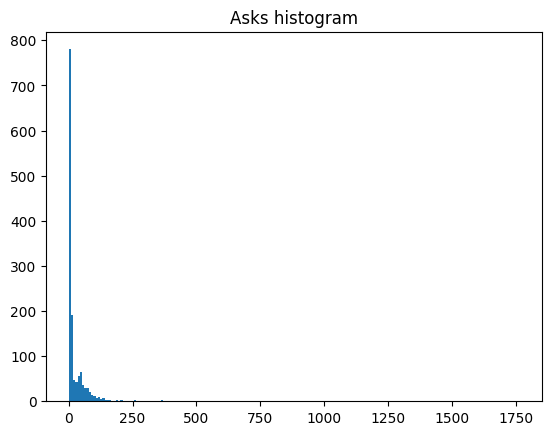

In [10]:
plt.hist(etf_ticks['total_bids'], bins=200)
plt.title("Bids histogram")
plt.show()
plt.hist(etf_ticks['total_asks'], bins=200)
plt.title("Asks histogram")
plt.show()

# This isn't nice
This data is pretty horrible. Let's start by splitting bids and asks so we can remove the zero spike.

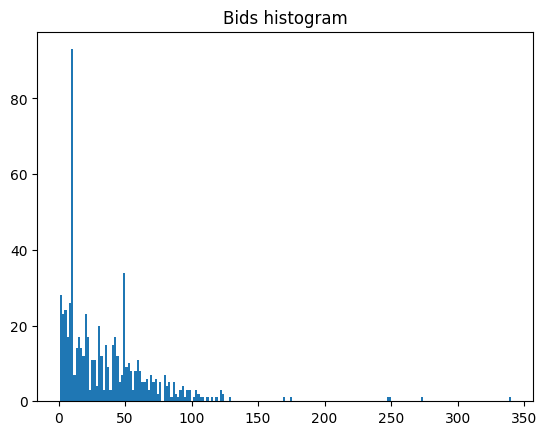

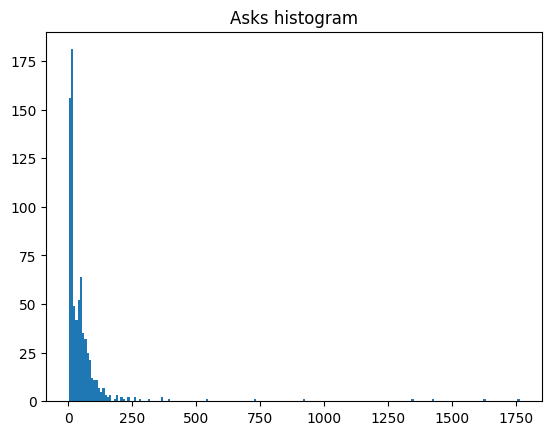

In [12]:
bid_ticks = etf_ticks[etf_ticks['total_bids'] != 0]
ask_ticks = etf_ticks[etf_ticks['total_asks'] != 0]
plt.hist(bid_ticks['total_bids'], bins=200)
plt.title("Bids histogram")
plt.show()
plt.hist(ask_ticks['total_asks'], bins=200)
plt.title("Asks histogram")
plt.show()

# This is much nicer!
We have a relationship that looks almost linear in the bids, and is much clearer.
Note we have some extreme outliers. I might cap each at some sensible value.
Now, the data is in a usable format!

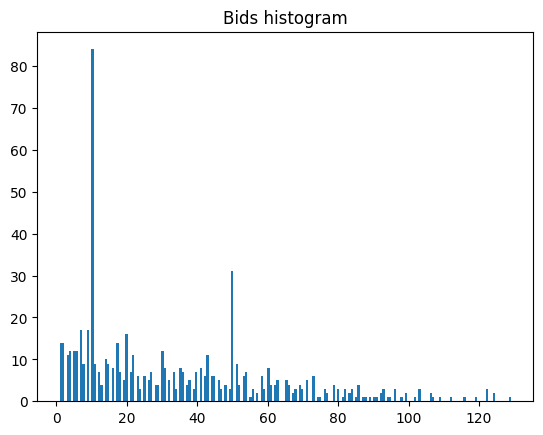

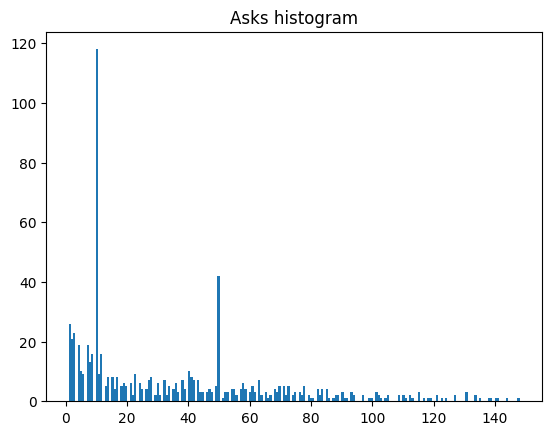

In [15]:
bid_ticks = bid_ticks[bid_ticks['total_bids'] < 150]
ask_ticks = ask_ticks[ask_ticks['total_asks'] < 150]
plt.hist(bid_ticks['total_bids'], bins=200)
plt.title("Bids histogram")
plt.show()
plt.hist(ask_ticks['total_asks'], bins=200)
plt.title("Asks histogram")
plt.show()

# Mid price movement
Now I must define my signals in order to investigate them.
I'll consider the average price movement of t ticks, given more than o orders

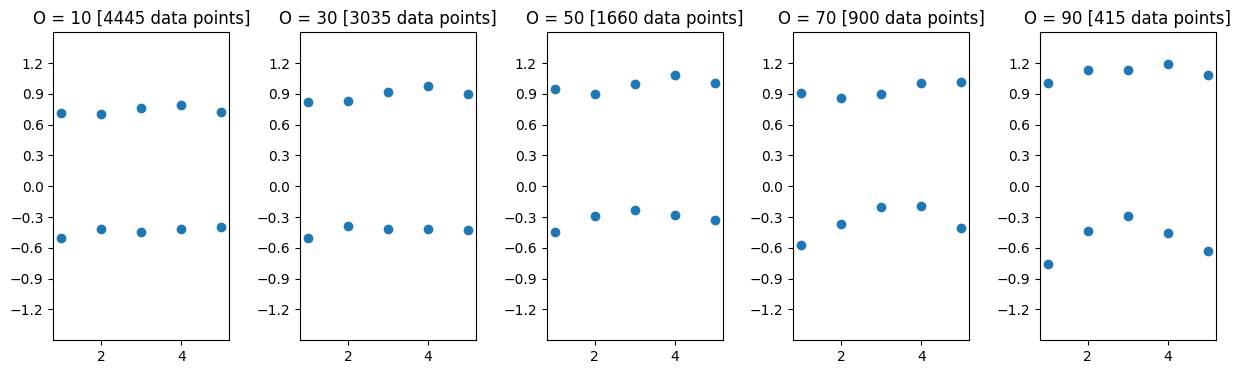

In [46]:
import numpy as np

ts = [1, 2, 3, 4, 5]
TIME_TICK = 0.25
os = [10, 30, 50, 70, 90]

def build_mid_shift(data, side, t, o):
    shifted_data = pd.DataFrame(columns=["time", t])

    # get trades that satisfy signal criteria
    relevant_trades = data[data["total_" + side] > o]

    # loop through every such trade
    for index, row in relevant_trades.iterrows():
        time = row['time']
        shift_data = {'time': time}

        # get the shift in mid price
        if (not etf_book[etf_book['time'] == time + t * TIME_TICK].empty) and (not etf_book[etf_book['time'] == time].empty):
            un_shifted_row = etf_book[etf_book['time'] == time].iloc[0]
            shifted_row = etf_book[etf_book['time'] == time + t * TIME_TICK].iloc[0]
            shift_data[t] = (shifted_row['mid'] - un_shifted_row['mid']) / 100
        else:
            shift_data[t] = 0

        # store it
        shifted_data.loc[len(shifted_data)] = pd.Series(shift_data)
    return shifted_data


# Create a grid of subplots
n = len(os)
fig, axes = plt.subplots(1, n, figsize=(15, 4))

# Flatten the 2D array of subplots to make indexing easier
axes = axes.flatten()

for (j, o) in enumerate(os):
    plot_data = [[], []]
    data_points = 0
    for (i, t) in enumerate(ts):
        for (data, side) in [[bid_ticks, "bids"], [ask_ticks, "asks"]]:
            mid_shift_data = build_mid_shift(data, side, t, o)
            data_points += len(mid_shift_data)
            plot_data[0] += [t]
            plot_data[1] += [mid_shift_data.mean()[t]]
    axes[j].scatter(
        plot_data[0],
        plot_data[1]
    )
    axes[j].set_ylim(-1.5, 1.5)
    axes[j].set_yticks(np.arange(-1.2, 1.3, 0.3))
    axes[j].set_title(f"O = {o} [{data_points} data points]")

# Adjust layout and show the plot
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

# Results
Interesting! The graphs are a little bit hard to interpret. It seems that as the trade size increases, the average market impact doesn't change much.
However, upon a trade happening, there is a market impact immediately of about a tick! That's great stuff. Very actionable.

Another interesting point of note is that the indicator gets worse as we increase the time-step. So trade ticks have an immediate market impact!!!